1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd

df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [27]:
df['default'] = df['default'].map({'Yes': 1, 'No': 0})
df['student'] = df['student'].map({'Yes': 1, 'No': 0})
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

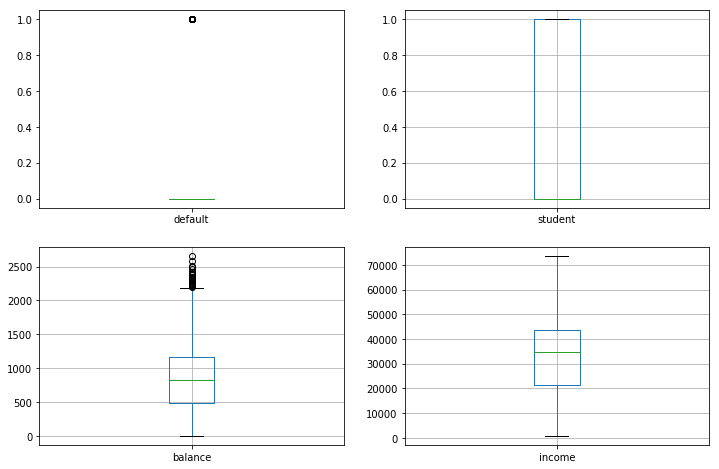

In [76]:
plt.subplots(figsize=(12,8))
plt.subplot(221)
df['default'].plot.box()
plt.subplot(222)
df['student'].plot.box()
plt.grid()
plt.subplot(223)
df['balance'].plot.box()
plt.grid()
plt.subplot(224)
df['income'].plot.box()
plt.grid()

plt.show()
plt.figure()



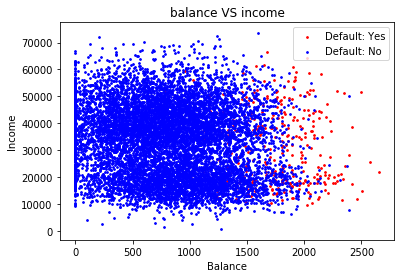

In [80]:
plt.scatter(df.loc[df['default'] == 1, 'balance'] , df.loc[df['default'] == 1, 'income'] ,s=3, color='r', label='Default: Yes')
plt.scatter(df.loc[df['default'] == 0, 'balance'] , df.loc[df['default'] == 0, 'income'], s=3, color = 'b', label='Default: No')
plt.ylabel('Income')
plt.xlabel('Balance')
plt.legend()
plt.title('balance VS income')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

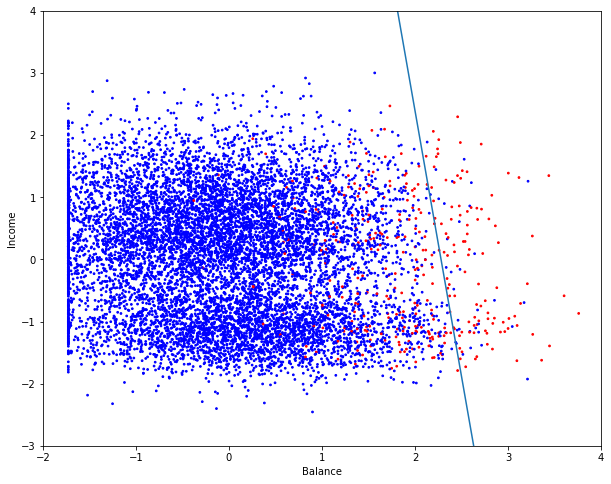

In [81]:
X = df[["balance","income"]]
y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=30)

regr = LogisticRegression(penalty='l1',C=1)
model=regr.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X[:,0],X[:,1],s=3,c = df['default'].apply(lambda x:colors[x]))
plt.xlabel("Balance")
plt.ylabel("Income")

bound = model.intercept_
coef = model.coef_[0]
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
x = np.arange(xmin,xmax)
y = (bound+coef[0]*x)/-coef[1]

plt.plot(x,y)
plt.xlim([-2,4])
plt.ylim([-3,4])
plt.show()

Area under the ROC curve : 0.948547


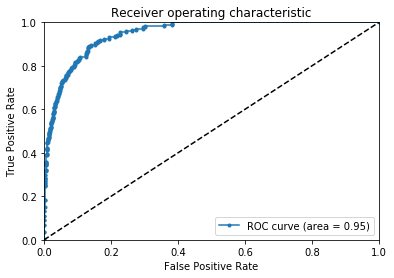

In [77]:
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

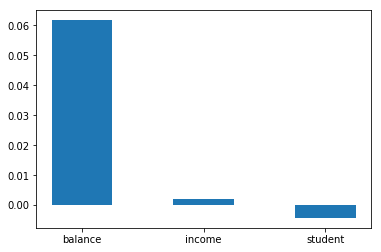

The coefficients for balance, income and student are shown respectively: [ 0.06172524  0.00212686 -0.00427   ].
Area under the ROC curve : 0.957912


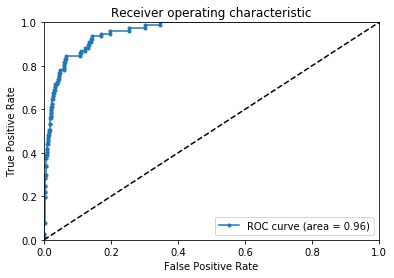

The performance does not have a great improvement when variables are added in.


In [128]:
from sklearn.linear_model import Ridge
X = df[['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 50)

alphas = np.logspace(-9, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
plt.show()
print ('The coefficients for balance, income and student are shown respectively: {0}.'.format(clf.coef_))

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("The performance does not have a great improvement when variables are added in.")

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [129]:
from sklearn.model_selection import cross_val_score

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

scores = cross_val_score(regr, X_train, y_train)
avg_score=mean(scores)
print'Cross validation score examples are ' + str(scores[:3])
print'Cross validation average score is ' + str(avg_score)
print("Because this cross validation has very high average score which are close to 1, so this model is robust")

Cross validation score examples are [ 0.97338831  0.9756189   0.97411853]
Cross validation average score is 0.974375246735
Because this cross validation has very high average score which are close to 1, so this model is robust


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

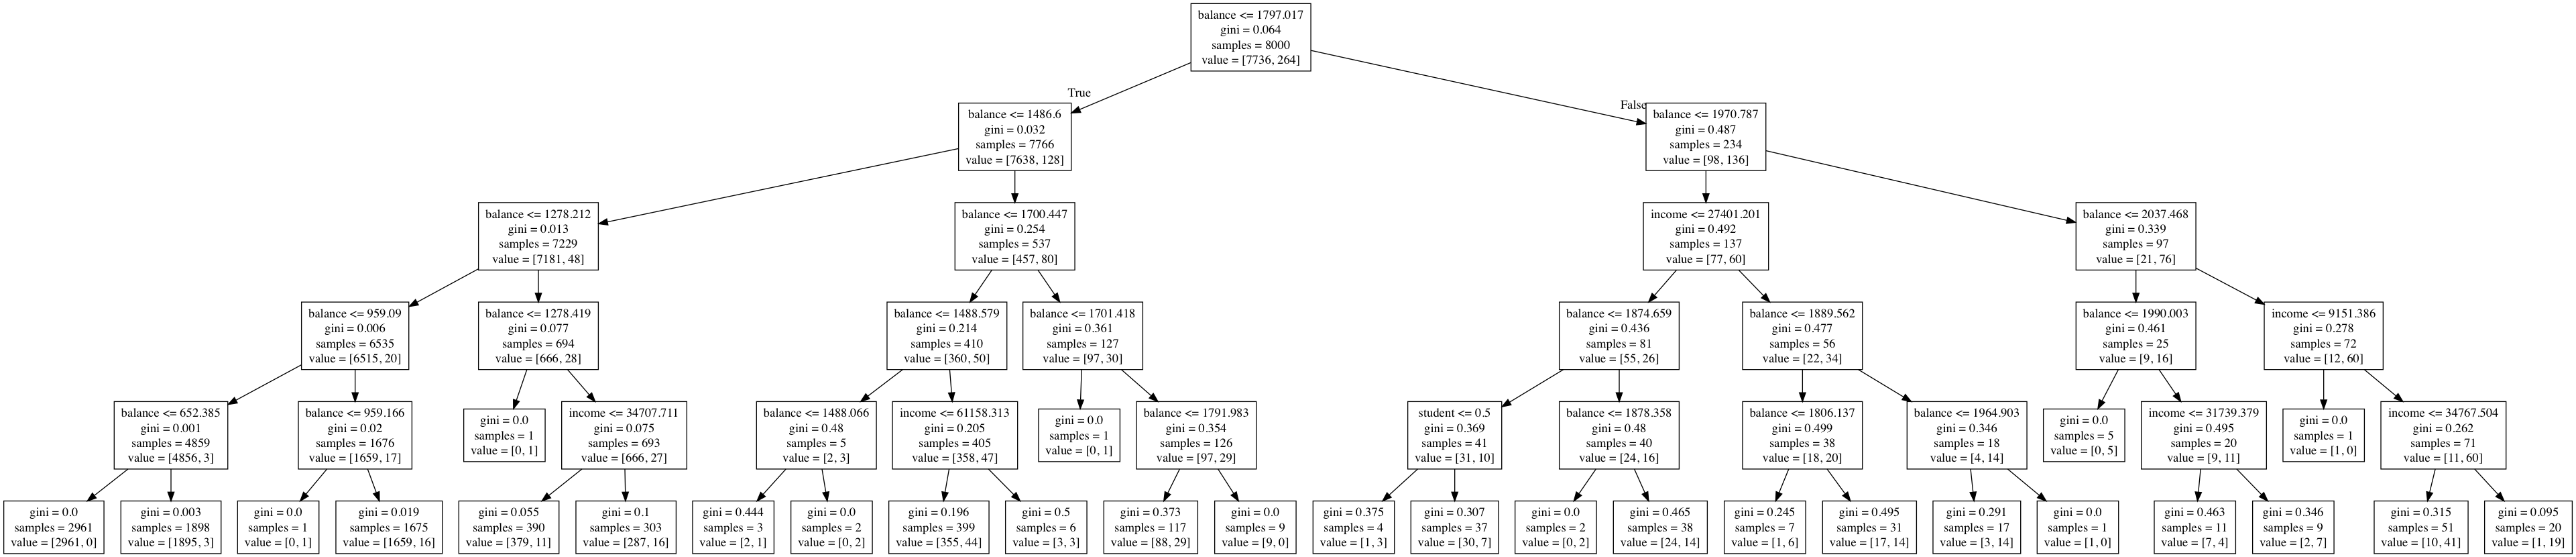

In [131]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

clf=DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Based on the observations I got from decision tree, compared to the classifier we had in part 5. Also, we have the ROC area calculated in part 8 are all close to 0.96 and the ROC are of part 5 is 0.96, so I found their performance are quite similar.

8) Find the optimal decision tree depth and compute the AUC ROC. 

ROC AUC with depth 1 have AUC equal to 0.9635
ROC AUC with depth 2 have AUC equal to 0.968
ROC AUC with depth 3 have AUC equal to 0.9685
ROC AUC with depth 4 have AUC equal to 0.968
ROC AUC with depth 5 have AUC equal to 0.969
ROC AUC with depth 6 have AUC equal to 0.966
ROC AUC with depth 7 have AUC equal to 0.966
ROC AUC with depth 8 have AUC equal to 0.9665
ROC AUC with depth 9 have AUC equal to 0.965
SO the Optimal Depth is 5


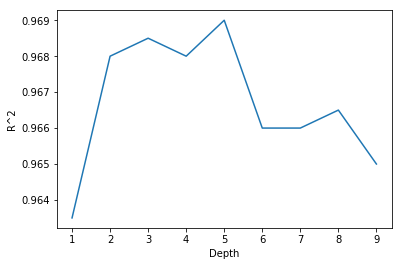

In [132]:
train_errors=[]
test_errors=[]
depths = range(1,10)
for n in depths:
    regre = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    regre.fit(X_train, y_train)
    train_errors.append(regre.score(X_train,y_train))
    test_errors.append(regre.score(X_test,y_test))
    print 'ROC AUC with depth ' + str(n) + ' have AUC equal to ' + str(regre.score(X_test,y_test))

plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,test_errors)
n_opt = depths[np.argmax(test_errors)]
print"SO the Optimal Depth is " + str(n_opt)
plt.show()

Area under the ROC curve : 0.687625


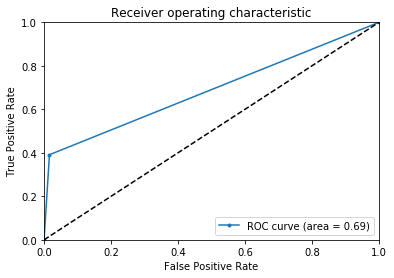

Max Depth = 1
Area under the ROC curve : 0.828181


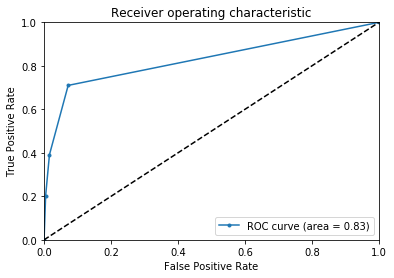

Max Depth = 2
Area under the ROC curve : 0.896562


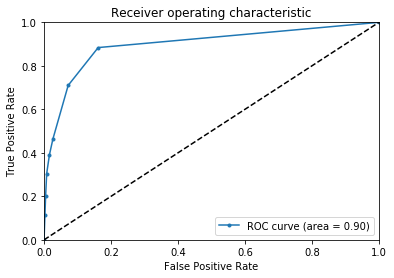

Max Depth = 3
Area under the ROC curve : 0.932550


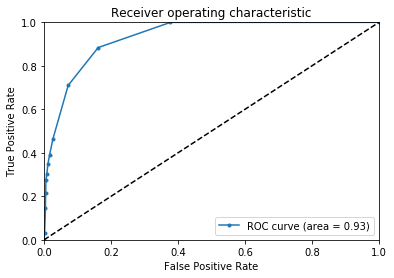

Max Depth = 4
Area under the ROC curve : 0.921757


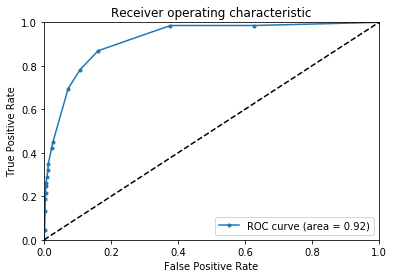

Max Depth = 5
Area under the ROC curve : 0.893049


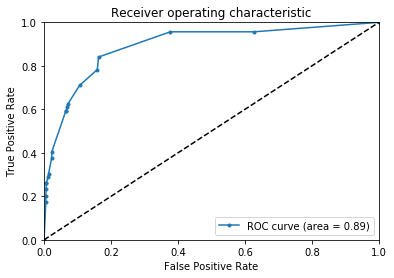

Max Depth = 6
Area under the ROC curve : 0.834508


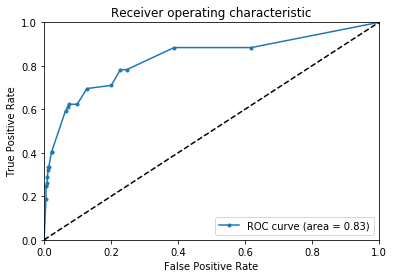

Max Depth = 7
Area under the ROC curve : 0.826504


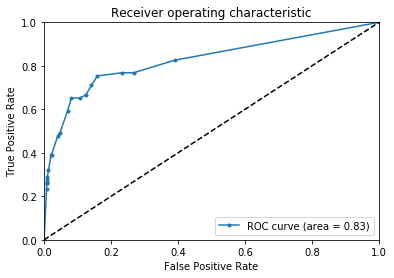

Max Depth = 8


In [133]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 1)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 1')
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 2)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 2')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 3)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 3')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 4')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 5')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 6')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 7)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 7')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 8)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 8')

From the figures above, in fact, I found the depth of 3 and 4 have higher AUC than depth 5, and depth of 4 has the highest AUC which is 0.9217